### Samples of fetching VaR calculatations from EnergyDesk

This first section loads a token from a local .env file 

In [1]:
# Import relevant libraries
import sys,os
from os.path import join, dirname
from dotenv import load_dotenv

sys.path.insert(1, os.path.join(sys.path[0], '..'))  # Hack to include parent directory in search path

# Loading token, url etc from .env file in current directory
load_dotenv('.env')
token = os.environ.get("ENERGYDESK_TOKEN")
server_url = os.environ.get("ENERGYDESK_URL")
print("Using server ", server_url)

Using server  http://127.0.0.1:8001


### Initialize the Python SDK which wraps sme useful REST calls ###

In [4]:
from energydeskapi.sdk.common_utils import init_api
from energydeskapi.customers.customers_api import CustomersApi
from energydeskapi.customers.users_api import UsersApi
from energydeskapi.portfolios.portfoliotree_api import PortfolioTreeApi, PortfoliosApi
from energydeskapi.types.company_enum_types import CompanyTypeEnum, CompanyRoleEnum
import pandas as pd

api_connection=init_api()
jsdata=PortfoliosApi.get_portfolios_embedded(api_connection)
df=pd.DataFrame(data=jsdata)
print(df[['pk', 'description']])


Not setting token   Token
Token setting token  866acd8205e5ddce9c9e8738cf18dfa029a813d0 Token
    pk            description
0    1               Trader 1
1    2               Trader 2
2    3               Trader 3
3    4     Industrikontrakter
4    5               Fastpris
5    6              GoO Total
6    7   HEV Hedging Exchange
7    8  HEV Hedging Bilateral
8    9            HEV Hedging
9   10            HEV Trading
10  11              HEV Total


## Calculate dVaR ##

{'price_days': 40, 'portfolio_id': 10}
    conf_level           ppf
0         0.01  9.387170e+06
1         0.02  8.505593e+06
2         0.03  7.946261e+06
3         0.04  7.525497e+06
4         0.05  7.183238e+06
..         ...           ...
94        0.95 -3.455572e+06
95        0.96 -3.797831e+06
96        0.97 -4.218594e+06
97        0.98 -4.777926e+06
98        0.99 -5.659503e+06

[99 rows x 2 columns]
1 day VaR @ 95% confidence: -3455571.93
2 day VaR @ 95% confidence: -4886916.69
3 day VaR @ 95% confidence: -5985226.16
4 day VaR @ 95% confidence: -6911143.86
5 day VaR @ 95% confidence: -7726893.74
6 day VaR @ 95% confidence: -8464388.0
7 day VaR @ 95% confidence: -9142583.97
8 day VaR @ 95% confidence: -9773833.38
9 day VaR @ 95% confidence: -10366715.8
10 day VaR @ 95% confidence: -10927477.92
11 day VaR @ 95% confidence: -11460835.53
12 day VaR @ 95% confidence: -11970452.31
13 day VaR @ 95% confidence: -12459241.79
14 day VaR @ 95% confidence: -12929566.24
15 day VaR @ 95% conf

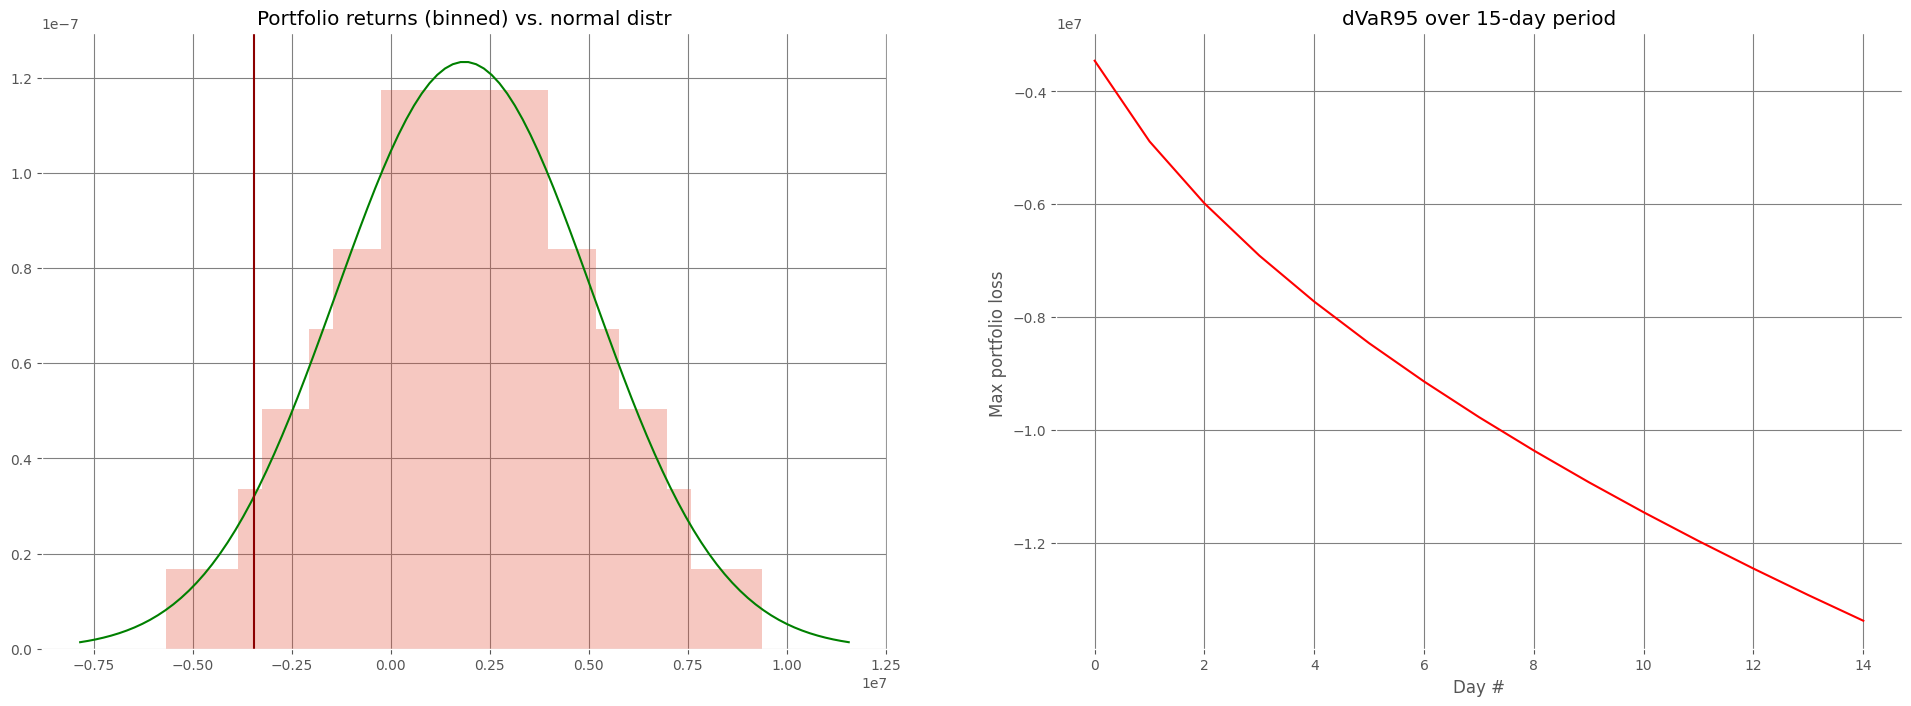

In [13]:
from energydeskapi.sdk.common_utils import init_api
from energydeskapi.assets.assets_api import AssetsApi
from energydeskapi.types.company_enum_types import CompanyTypeEnum, CompanyRoleEnum
import pandas as pd
import matplotlib.mlab as mlab
import numpy as np
import matplotlib
import scipy
from scipy.stats import norm
from matplotlib import pyplot as plt
from energydeskapi.risk.risk_api import RiskApi

df_varbins, portfolio_mean, portfolio_stdev = RiskApi.calc_covariance_var_df(api_connection,                        
                                                      portfolio_id=10, days_back=40)
x = np.linspace(portfolio_mean - 3*portfolio_stdev, portfolio_mean+3*portfolio_stdev,100)

print(df_varbins)
df_varbins.index=df_varbins.conf_level
df_varbins=df_varbins.drop(['conf_level'], axis=1)

plt.style.use('ggplot')
plt.rcParams.update({"figure.figsize" : (24, 8)})
matplotlib.rcParams['grid.color'] = 'gray'
matplotlib.rcParams['figure.facecolor'] = "white"#(0.0, 0.0, 0.0, 0.1)
matplotlib.rcParams['axes.facecolor'] = "white"#(0.0, 0.0, 0.0, 0.1)
fig, (ax1, ax2) = plt.subplots(1, 2)


ax1.hist(df_varbins, bins=25, alpha=0.3, density=True)
vals = norm.ppf([0.001, 0.5, 0.999])
ax1.plot(x, scipy.stats.norm.pdf(x, portfolio_mean, portfolio_stdev), "g")

varval95=df_varbins[df_varbins.index == 0.95]['ppf'].values[0]
varval99 = df_varbins[df_varbins.index == 0.99]['ppf'].values[0]
ax1.axvline(x=varval95, color='darkred')
bottom, top = matplotlib.pyplot.ylim()
ax1.set_title("Portfolio returns (binned) vs. normal distr")

        
# Calculate n Day VaR
var_array = []
num_days = int(15)
for x in range(1, num_days+1):    
    var_array.append(np.round(varval95 * np.sqrt(x),2))
    print(str(x) + " day VaR @ 95% confidence: " + str(np.round(varval95 * np.sqrt(x),2)))

# Build plot
ax2.set_xlabel("Day #")
ax2.set_ylabel("Max portfolio loss ")
ax2.set_title("dVaR95 over 15-day period")
ax2.plot(var_array, "r")
plt.show()